# 实操：基于 DeltaFQ 实现多因子策略（v0.5.0）

本教程将演示如何使用 DeltaFQ 实现一个多因子量化策略，通过组合多个技术指标来生成更稳健的交易信号。

## 策略参数设置

- **标的**: AAPL（苹果公司）
- **基准**: SPY（标普500 ETF）
- **回测周期**: 2024-01-01 至 2024-12-31
- **多因子组合**: SMA、EMA、RSI、KDJ、BOLL、OBV
- **信号组合方法**: 投票法（vote）
- **交易参数**: 初始资金=1,000,000，手续费=0.1%，滑点=0.05%

## 策略逻辑

### 单因子信号生成

1. **SMA信号**: 快线（10日）上穿慢线（20日）买入，下穿卖出
2. **EMA信号**: 价格上穿EMA（20日）买入，下穿卖出
3. **RSI信号**: RSI < 30 买入，RSI > 70 卖出
4. **KDJ信号**: K线上穿D线买入，下穿卖出
5. **BOLL信号**: 价格上穿布林带下轨买入，下穿上轨卖出
6. **OBV信号**: OBV斜率向上买入，向下卖出

### 多因子信号组合

使用**投票法（vote）**组合多个因子：
- 统计每个时间点的买入票数和卖出票数
- 买入票数 > 卖出票数 → 买入信号（1）
- 卖出票数 > 买入票数 → 卖出信号（-1）
- 否则 → 持有信号（0）

## 实现方式

本教程使用 **BaseStrategy + BacktestEngine** 方式实现，代码简洁高效。


In [1]:
# 导入必要的库
import deltafq as dfq
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 全局参数设置
ticker = "AAPL"  # 苹果公司
benchmark_ticker = "SPY"  # 标普500 ETF
start_date = "2024-01-01"
end_date = "2024-12-31"

# 各因子参数
sma_fast_period = 10
sma_slow_period = 20
ema_period = 20
rsi_period = 14
rsi_oversold = 30
rsi_overbought = 70
kdj_n = 9
kdj_m1 = 3
kdj_m2 = 3
boll_period = 20
boll_std_dev = 2

# 交易参数
initial_capital = 1_000_000
commission = 0.001  # 0.1%
slippage = 0.0005  # 0.05%

print("✅ 参数设置完成")
print(f"标的: {ticker}")
print(f"基准: {benchmark_ticker}")
print(f"回测周期: {start_date} 至 {end_date}")
print(f"多因子: SMA({sma_fast_period}/{sma_slow_period}), EMA({ema_period}), RSI({rsi_period}), KDJ({kdj_n}/{kdj_m1}/{kdj_m2}), BOLL({boll_period}/{boll_std_dev}), OBV")
print(f"信号组合方法: 投票法（vote）")
print(f"初始资金: {initial_capital:,.0f}, 手续费: {commission*100}%, 滑点: {slippage*100}%")


✅ 参数设置完成
标的: AAPL
基准: SPY
回测周期: 2024-01-01 至 2024-12-31
多因子: SMA(10/20), EMA(20), RSI(14), KDJ(9/3/3), BOLL(20/2), OBV
信号组合方法: 投票法（vote）
初始资金: 1,000,000, 手续费: 0.1%, 滑点: 0.05%


## 步骤1：定义多因子策略类

继承 `BaseStrategy`，实现 `generate_signals` 方法，计算多个技术指标并组合信号。


In [2]:
class MultiFactorStrategy(dfq.strategy.BaseStrategy):
    """多因子策略：组合SMA、EMA、RSI、KDJ、BOLL、OBV多个技术指标"""
    
    def __init__(self, 
                 sma_fast_period=10, sma_slow_period=20,
                 ema_period=20,
                 rsi_period=14, rsi_oversold=30, rsi_overbought=70,
                 kdj_n=9, kdj_m1=3, kdj_m2=3,
                 boll_period=20, boll_std_dev=2,
                 combine_method='vote',
                 **kwargs):
        """
        初始化多因子策略
        
        参数:
            sma_fast_period: SMA快线周期
            sma_slow_period: SMA慢线周期
            ema_period: EMA周期
            rsi_period: RSI周期
            rsi_oversold: RSI超卖阈值
            rsi_overbought: RSI超买阈值
            kdj_n: KDJ的RSV周期
            kdj_m1: KDJ的K线平滑周期
            kdj_m2: KDJ的D线平滑周期
            boll_period: 布林带周期
            boll_std_dev: 布林带标准差倍数
            combine_method: 信号组合方法 ('vote', 'weighted', 'threshold')
        """
        super().__init__(name="MultiFactorStrategy", **kwargs)
        self.sma_fast_period = sma_fast_period
        self.sma_slow_period = sma_slow_period
        self.ema_period = ema_period
        self.rsi_period = rsi_period
        self.rsi_oversold = rsi_oversold
        self.rsi_overbought = rsi_overbought
        self.kdj_n = kdj_n
        self.kdj_m1 = kdj_m1
        self.kdj_m2 = kdj_m2
        self.boll_period = boll_period
        self.boll_std_dev = boll_std_dev
        self.combine_method = combine_method
        
        # 初始化技术指标和信号生成器
        self.indicators = dfq.indicators.TechnicalIndicators()
        self.signal_generator = dfq.strategy.SignalGenerator()
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """
        生成多因子交易信号
        
        参数:
            data: 包含OHLCV数据的DataFrame
            
        返回:
            交易信号Series（1=买入, -1=卖出, 0=持有）
        """
        # 提取价格和成交量数据
        close = data["Close"]
        high = data["High"]
        low = data["Low"]
        volume = data["Volume"]
        
        # 1. 计算SMA信号
        sma_fast = self.indicators.sma(close, period=self.sma_fast_period)
        sma_slow = self.indicators.sma(close, period=self.sma_slow_period)
        sma_signal = self.signal_generator.sma_signals(sma_fast, sma_slow)
        
        # 2. 计算EMA信号
        ema = self.indicators.ema(close, period=self.ema_period)
        ema_signal = self.signal_generator.ema_signals(close, ema)
        
        # 3. 计算RSI信号
        rsi = self.indicators.rsi(close, period=self.rsi_period, method='rma')
        rsi_signal = self.signal_generator.rsi_signals(
            rsi, 
            oversold=self.rsi_oversold, 
            overbought=self.rsi_overbought
        )
        
        # 4. 计算KDJ信号
        kdj = self.indicators.kdj(
            high, low, close,
            n=self.kdj_n, m1=self.kdj_m1, m2=self.kdj_m2,
            method='sma'
        )
        kdj_signal = self.signal_generator.kdj_signals(kdj)
        
        # 5. 计算BOLL信号
        boll = self.indicators.boll(
            close, 
            period=self.boll_period, 
            std_dev=self.boll_std_dev,
            method='population'
        )
        boll_signal = self.signal_generator.boll_signals(close, boll, method="cross")
        
        # 6. 计算OBV信号
        obv = self.indicators.obv(close, volume)
        obv_signal = self.signal_generator.obv_signals(obv)
        
        # 7. 组合多个信号
        signals_dict = {
            "sma": sma_signal,
            "ema": ema_signal,
            "rsi": rsi_signal,
            "kdj": kdj_signal,
            "boll": boll_signal,
            "obv": obv_signal,
        }
        
        combined_signal = self.signal_generator.combine_signals(
            signals_dict,
            method=self.combine_method
        )
        
        return combined_signal

print("✅ 多因子策略类定义完成")


✅ 多因子策略类定义完成


## 步骤2：初始化回测引擎并设置参数


In [3]:
# 初始化回测引擎
engine = dfq.backtest.BacktestEngine(
    initial_capital=initial_capital,
    commission=commission,
    slippage=slippage,
    data_source="yahoo"
)

# 设置回测参数
engine.set_parameters(
    symbol=ticker,
    start_date=start_date,
    end_date=end_date,
    benchmark=benchmark_ticker,
    initial_capital=initial_capital,
    commission=commission,
    slippage=slippage
)

print("✅ 回测引擎初始化完成")


[13:56:04] BacktestEngine       >>> INFO     >>> Initializing backtest engine
[13:56:04] DataFetcher          >>> INFO     >>> Initializing data fetcher with source: yahoo
[13:56:04] DataStorage          >>> INFO     >>> Initializing data storage at: C:\Users\leek_\Desktop\Delta\imooc\deltafq\examples\data_cache
[13:56:04] PerformanceReporter  >>> INFO     >>> Initializing performance reporter
[13:56:04] PerformanceChart     >>> INFO     >>> Initializing performance chart
[13:56:04] OrderManager         >>> INFO     >>> Initializing order manager
[13:56:04] PositionManager      >>> INFO     >>> Initializing position manager
[13:56:04] OrderManager         >>> INFO     >>> Initializing order manager
[13:56:04] PositionManager      >>> INFO     >>> Initializing position manager
[13:56:04] DataFetcher          >>> INFO     >>> Initializing data fetcher with source: yahoo
✅ 回测引擎初始化完成


## 步骤3：加载数据


In [4]:
# 加载历史数据
data = engine.load_data()

print(f"✅ 数据加载完成")
print(f"数据形状: {data.shape}")
print(f"数据日期范围: {data.index[0]} 至 {data.index[-1]}")
print(f"\n数据预览:")
print(data.head())


[13:56:04] DataFetcher          >>> INFO     >>> Fetching data for AAPL from 2024-01-01 to 2024-12-31
[13:56:07] DataCleaner          >>> INFO     >>> Initializing data cleaner
[13:56:07] DataCleaner          >>> INFO     >>> Dropped NaN rows: 251 -> 251 rows
✅ 数据加载完成
数据形状: (251, 5)
数据日期范围: 2024-01-02 00:00:00 至 2024-12-30 00:00:00

数据预览:
Price            Close        High         Low        Open    Volume
Date                                                                
2024-01-02  183.903229  186.677036  182.169601  185.399096  82488700
2024-01-03  182.526245  184.141000  181.713909  182.496527  58414500
2024-01-04  180.208115  181.377068  179.187752  180.445860  71983600
2024-01-05  179.484955  181.050175  178.484409  180.287390  62379700
2024-01-08  183.823975  183.863609  179.801961  180.386437  59144500


## 步骤4：创建策略实例并添加到引擎


In [5]:
# 创建多因子策略实例
strategy = MultiFactorStrategy(
    sma_fast_period=sma_fast_period,
    sma_slow_period=sma_slow_period,
    ema_period=ema_period,
    rsi_period=rsi_period,
    rsi_oversold=rsi_oversold,
    rsi_overbought=rsi_overbought,
    kdj_n=kdj_n,
    kdj_m1=kdj_m1,
    kdj_m2=kdj_m2,
    boll_period=boll_period,
    boll_std_dev=boll_std_dev,
    combine_method='vote'
)

# 将策略添加到引擎（引擎会自动调用generate_signals生成信号）
engine.add_strategy(strategy)

print("✅ 策略已添加到引擎")


[13:56:07] MultiFactorStrategy  >>> INFO     >>> Initializing strategy: MultiFactorStrategy
[13:56:07] TechnicalIndicators  >>> INFO     >>> Initializing technical indicators
[13:56:07] SignalGenerator      >>> INFO     >>> Initializing signal generator
[13:56:07] MultiFactorStrategy  >>> INFO     >>> Running strategy: MultiFactorStrategy
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=10)
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=20)
[13:56:07] SignalGenerator      >>> INFO     >>> SMA crossover signals -> buy=136, sell=96, flat=19
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating EMA(period=20, method=pandas)
[13:56:07] SignalGenerator      >>> INFO     >>> EMA price-vs-ema signals -> buy=154, sell=96, flat=1
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating RSI(period=14, method=rma)
[13:56:07] SignalGenerator      >>> INFO     >>> RSI signals -> buy=5, sell=38, flat=208
[13:56:07] TechnicalIndicators  >>> I

## 步骤5：执行回测


In [6]:
# 执行回测
trades_df, values_df = engine.run_backtest(save_csv=True, strategy_name="MultiFactor")

print("✅ 回测执行完成")
print(f"\n交易记录数量: {len(trades_df)}")
print(f"净值记录数量: {len(values_df)}")
print(f"\n交易记录预览:")
print(trades_df.head(10))


[13:56:07] OrderManager         >>> INFO     >>> Order created: ORD_000001
[13:56:07] PositionManager      >>> INFO     >>> Position updated: AAPL -> 5434
[13:56:07] ExecutionEngine      >>> INFO     >>> Order executed - paper trading: ORD_000001, date: 2024-01-08, price: 183.823974609375, quantity: 5434
[13:56:07] OrderManager         >>> INFO     >>> Order created: ORD_000002
[13:56:07] PositionManager      >>> INFO     >>> Position reduced: AAPL -> 0
[13:56:07] ExecutionEngine      >>> INFO     >>> Order executed - paper trading: ORD_000002, date: 2024-01-16, price: 181.9120330810547, quantity: -5434
[13:56:07] OrderManager         >>> INFO     >>> Order created: ORD_000003
[13:56:07] PositionManager      >>> INFO     >>> Position updated: AAPL -> 5279
[13:56:07] ExecutionEngine      >>> INFO     >>> Order executed - paper trading: ORD_000003, date: 2024-01-18, price: 186.86524963378906, quantity: 5279
[13:56:07] OrderManager         >>> INFO     >>> Order created: ORD_000004
[13:56

## 步骤6：查看各因子信号统计

让我们查看一下各个因子的信号分布情况，了解每个因子的贡献。


In [7]:
# 重新计算各因子信号用于分析
indicators = dfq.indicators.TechnicalIndicators()
signal_gen = dfq.strategy.SignalGenerator()

close = data["Close"]
high = data["High"]
low = data["Low"]
volume = data["Volume"]

# 计算各因子信号
sma_fast = indicators.sma(close, period=sma_fast_period)
sma_slow = indicators.sma(close, period=sma_slow_period)
sma_signal = signal_gen.sma_signals(sma_fast, sma_slow)

ema = indicators.ema(close, period=ema_period)
ema_signal = signal_gen.ema_signals(close, ema)

rsi = indicators.rsi(close, period=rsi_period, method='rma')
rsi_signal = signal_gen.rsi_signals(rsi, oversold=rsi_oversold, overbought=rsi_overbought)

kdj = indicators.kdj(high, low, close, n=kdj_n, m1=kdj_m1, m2=kdj_m2, method='sma')
kdj_signal = signal_gen.kdj_signals(kdj)

boll = indicators.boll(close, period=boll_period, std_dev=boll_std_dev, method='population')
boll_signal = signal_gen.boll_signals(close, boll, method="cross")

obv = indicators.obv(close, volume)
obv_signal = signal_gen.obv_signals(obv)

# 组合信号
combined_signal = signal_gen.combine_signals({
    "sma": sma_signal,
    "ema": ema_signal,
    "rsi": rsi_signal,
    "kdj": kdj_signal,
    "boll": boll_signal,
    "obv": obv_signal,
}, method='vote')

# 统计各因子信号
signal_stats = pd.DataFrame({
    "买入信号": [
        (sma_signal == 1).sum(),
        (ema_signal == 1).sum(),
        (rsi_signal == 1).sum(),
        (kdj_signal == 1).sum(),
        (boll_signal == 1).sum(),
        (obv_signal == 1).sum(),
        (combined_signal == 1).sum(),
    ],
    "卖出信号": [
        (sma_signal == -1).sum(),
        (ema_signal == -1).sum(),
        (rsi_signal == -1).sum(),
        (kdj_signal == -1).sum(),
        (boll_signal == -1).sum(),
        (obv_signal == -1).sum(),
        (combined_signal == -1).sum(),
    ],
    "持有信号": [
        (sma_signal == 0).sum(),
        (ema_signal == 0).sum(),
        (rsi_signal == 0).sum(),
        (kdj_signal == 0).sum(),
        (boll_signal == 0).sum(),
        (obv_signal == 0).sum(),
        (combined_signal == 0).sum(),
    ],
}, index=["SMA", "EMA", "RSI", "KDJ", "BOLL", "OBV", "组合信号"])

print("各因子信号统计:")
print(signal_stats)


[13:56:07] TechnicalIndicators  >>> INFO     >>> Initializing technical indicators
[13:56:07] SignalGenerator      >>> INFO     >>> Initializing signal generator
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=10)
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=20)
[13:56:07] SignalGenerator      >>> INFO     >>> SMA crossover signals -> buy=136, sell=96, flat=19
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating EMA(period=20, method=pandas)
[13:56:07] SignalGenerator      >>> INFO     >>> EMA price-vs-ema signals -> buy=154, sell=96, flat=1
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating RSI(period=14, method=rma)
[13:56:07] SignalGenerator      >>> INFO     >>> RSI signals -> buy=5, sell=38, flat=208
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating KDJ(n=9, m1=3, m2=3, method=sma)
[13:56:07] TechnicalIndicators  >>> INFO     >>> Calculating SMA(period=3)
[13:56:07] TechnicalIndicators  >>> INFO     >>

## 步骤7：生成绩效报告


In [8]:
# 生成绩效报告（使用引擎内置方法）
print("\n【步骤7】生成绩效报告")
engine.show_report()



【步骤7】生成绩效报告

  策略回测报告

【日期信息】
  首个交易日: 2024-01-02 00:00:00
  最后交易日: 2024-12-30 00:00:00
  总交易日: 251
  盈利交易日: 92
  亏损交易日: 88

【资金信息】
  起始资金: 1,000,000.00
  结束资金: 1,066,787.21
  资金增长: 66,787.21 (6.68%)

【收益指标】
  总收益率: 6.68%
  年化收益: 8.27%
  日均收益率: 0.03%

【风险指标】
  最大回撤: -14.08%
  收益标准差: 1.08%
  波动率: 17.15%

【绩效指标】
  夏普比率: 0.46
  收益回撤比: 0.59
  交易胜率: 33.33%
  盈亏比: 2.31
  平均盈利: 46,104.88
  平均亏损: -19,933.60

【交易统计】
  总盈亏: 254,812.34
  总手续费: 49,301.47
  总成交额: 24,175,391.99
  总成交笔数: 49

【日均统计】
  日均盈亏: 198.81
  日均手续费: 196.42
  日均成交额: 96,316.30
  日均成交笔数: 0.20




## 步骤8：可视化回测结果



【步骤8】可视化结果
[13:56:07] DataFetcher          >>> INFO     >>> Fetching data for SPY from 2024-01-01 to 2024-12-31
[13:56:09] DataCleaner          >>> INFO     >>> Dropped NaN rows: 251 -> 251 rows


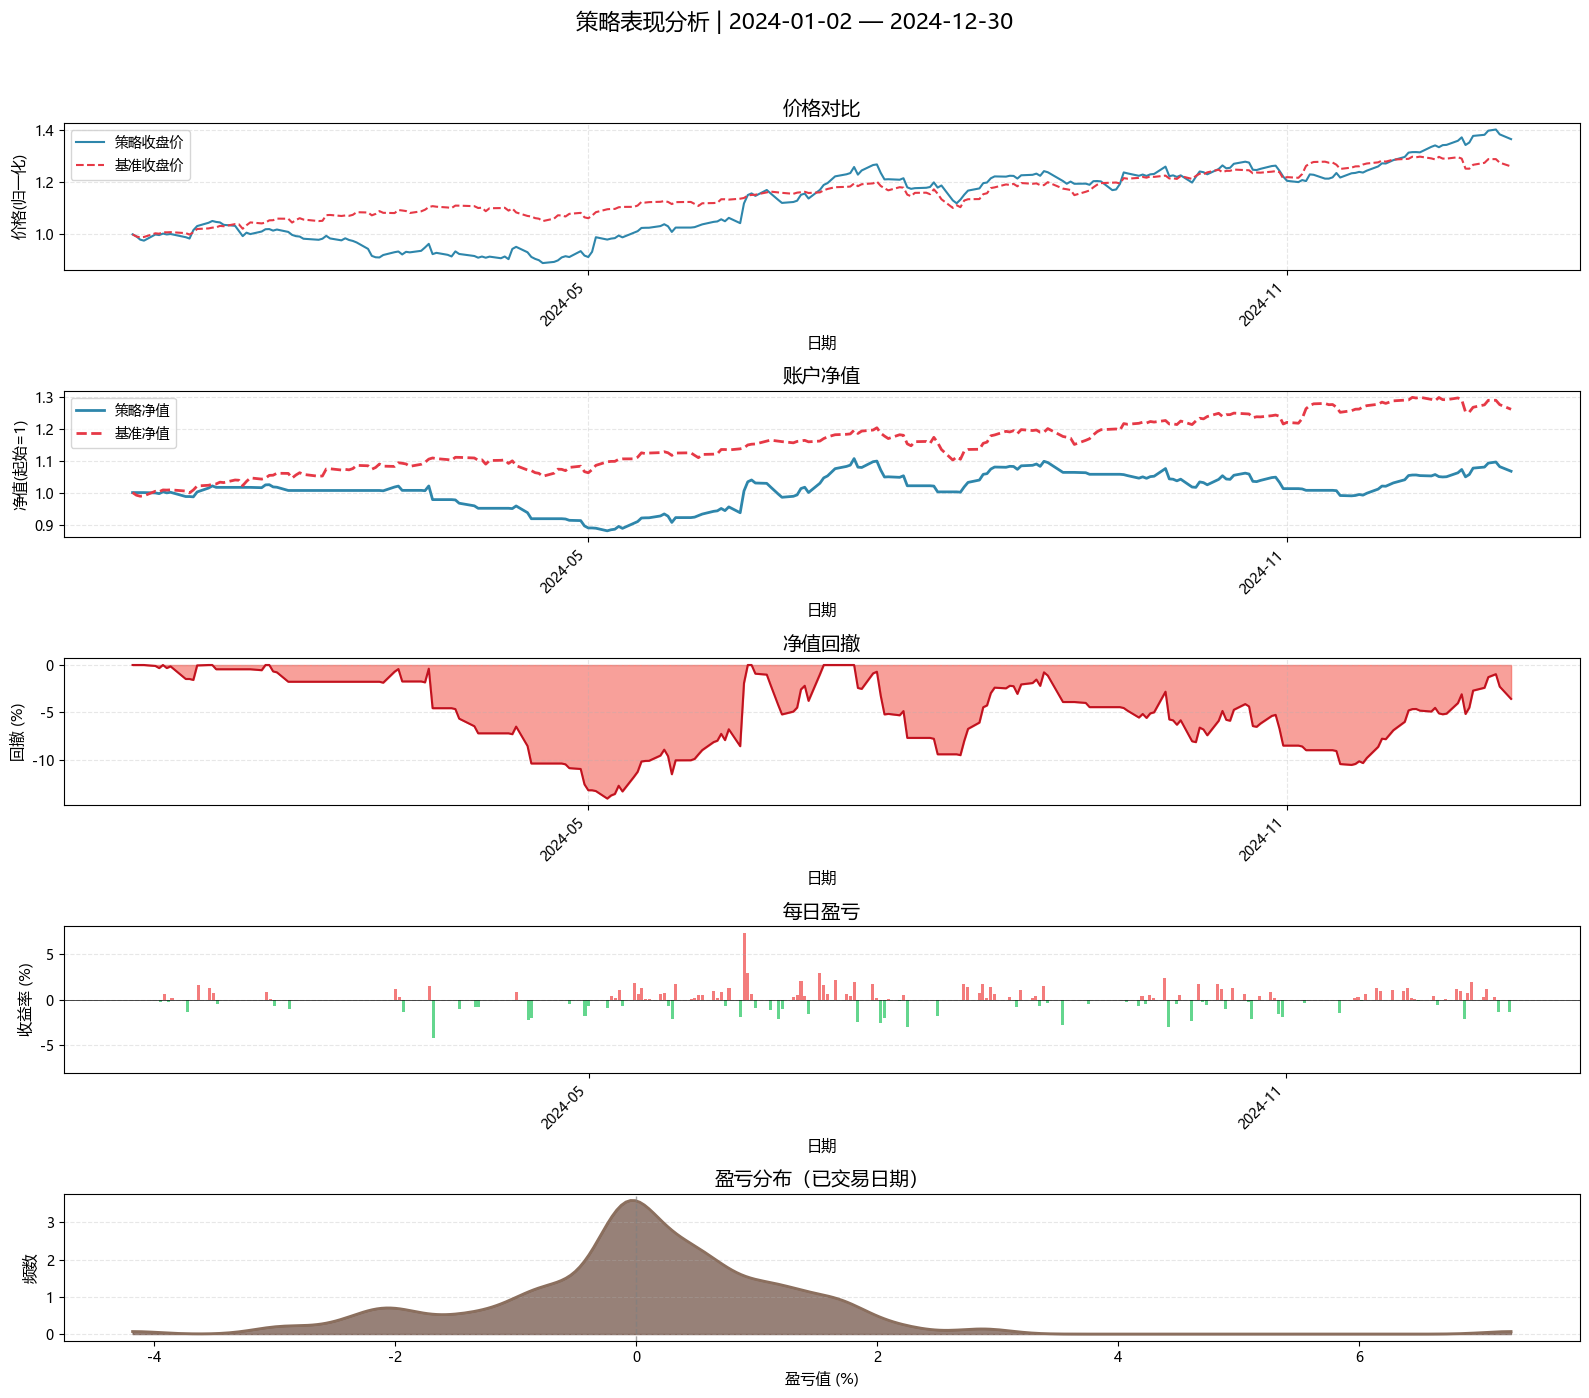

In [9]:
# 可视化结果（使用引擎内置方法）
print("\n【步骤8】可视化结果")
engine.show_chart(use_plotly=False)


## 总结

本教程演示了如何使用 DeltaFQ 实现多因子量化策略：

### 关键要点

1. **多因子策略的优势**：
   - 通过组合多个技术指标，可以降低单一因子的噪音影响
   - 投票法（vote）能够综合多个因子的意见，生成更稳健的信号
   - 不同因子在不同市场环境下可能有不同的表现，组合使用可以提高策略的适应性

2. **实现方式**：
   - 继承 `BaseStrategy` 类，实现 `generate_signals` 方法
   - 使用 `TechnicalIndicators` 计算各种技术指标
   - 使用 `SignalGenerator` 生成单因子信号
   - 使用 `SignalGenerator.combine_signals()` 组合多个信号
   - 使用 `BacktestEngine` 执行回测和生成报告

3. **信号组合方法**：
   - **投票法（vote）**：统计买入和卖出票数，多数决定
   - **加权法（weighted）**：根据权重加权求和，适合不同重要性的因子
   - **阈值法（threshold）**：加权求和后与阈值比较，适合需要更强信号的场景

4. **可扩展性**：
   - 可以轻松添加新的技术指标和信号生成逻辑
   - 可以调整各因子的参数进行优化
   - 可以尝试不同的信号组合方法

### 下一步优化方向

- **参数优化**：使用网格搜索或优化算法寻找最佳参数组合
- **因子权重**：根据历史表现给不同因子分配不同权重
- **动态调整**：根据市场状态动态调整因子权重或组合方法
- **风险管理**：添加止损、止盈等风险管理机制
- **因子筛选**：通过相关性分析等方法筛选有效因子
